In [1]:
#Import the things
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [13]:
#Save the data
df=pd.read_csv("healthcare-dataset-stroke-data.csv")

In [14]:
#Visualize the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [50]:
# Clean the data (Remove NaNs & id)
df = df.dropna()
df.drop(['id'],  axis=1, inplace=True)

In [47]:
#Visualize non-numerical data to see what should be droped and how best to convert it to numerical classes
print('Gender Classes:', df['gender'].unique())
print('Married Classes:', df['ever_married'].unique())
print('Work Type Classes:', df['work_type'].unique())
print('Residence Classes:', df['Residence_type'].unique())
print('Smoking Classes:', df['smoking_status'].unique())

Gender Classes: ['Male' 'Female' 'Other']
Married Classes: ['Yes' 'No']
Work Type Classes: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence Classes: ['Urban' 'Rural']
Smoking Classes: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [48]:
#Now lets drop the classes that will muddle the results... "Other", "Unknown"
df = df[df['smoking_status'] != 'Unknown']
df = df[df['gender'] != 'Other']

In [51]:
#Now convert to numerical. Most can be done with label encoder, cases with only two classes or classes that are completely unrelated
#HOWEVER, cases with more than 2, and they could act as a scale (i.e. never smokes->Used to smoke->currently smokes), we need to specify how it is done
le=LabelEncoder()
df["LE_gender"] = le.fit_transform(df['gender'])
df["LE_ever_married"] = le.fit_transform(df['ever_married'])
df["LE_Residence_type"] = le.fit_transform(df['Residence_type'])
df["LE_work_type"] = le.fit_transform(df['work_type'])

In [52]:
#For those special cases, we gotta define it ourselves.
smoking_map = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2
}

df['LE_smoking_status'] = df['smoking_status'].map(smoking_map)

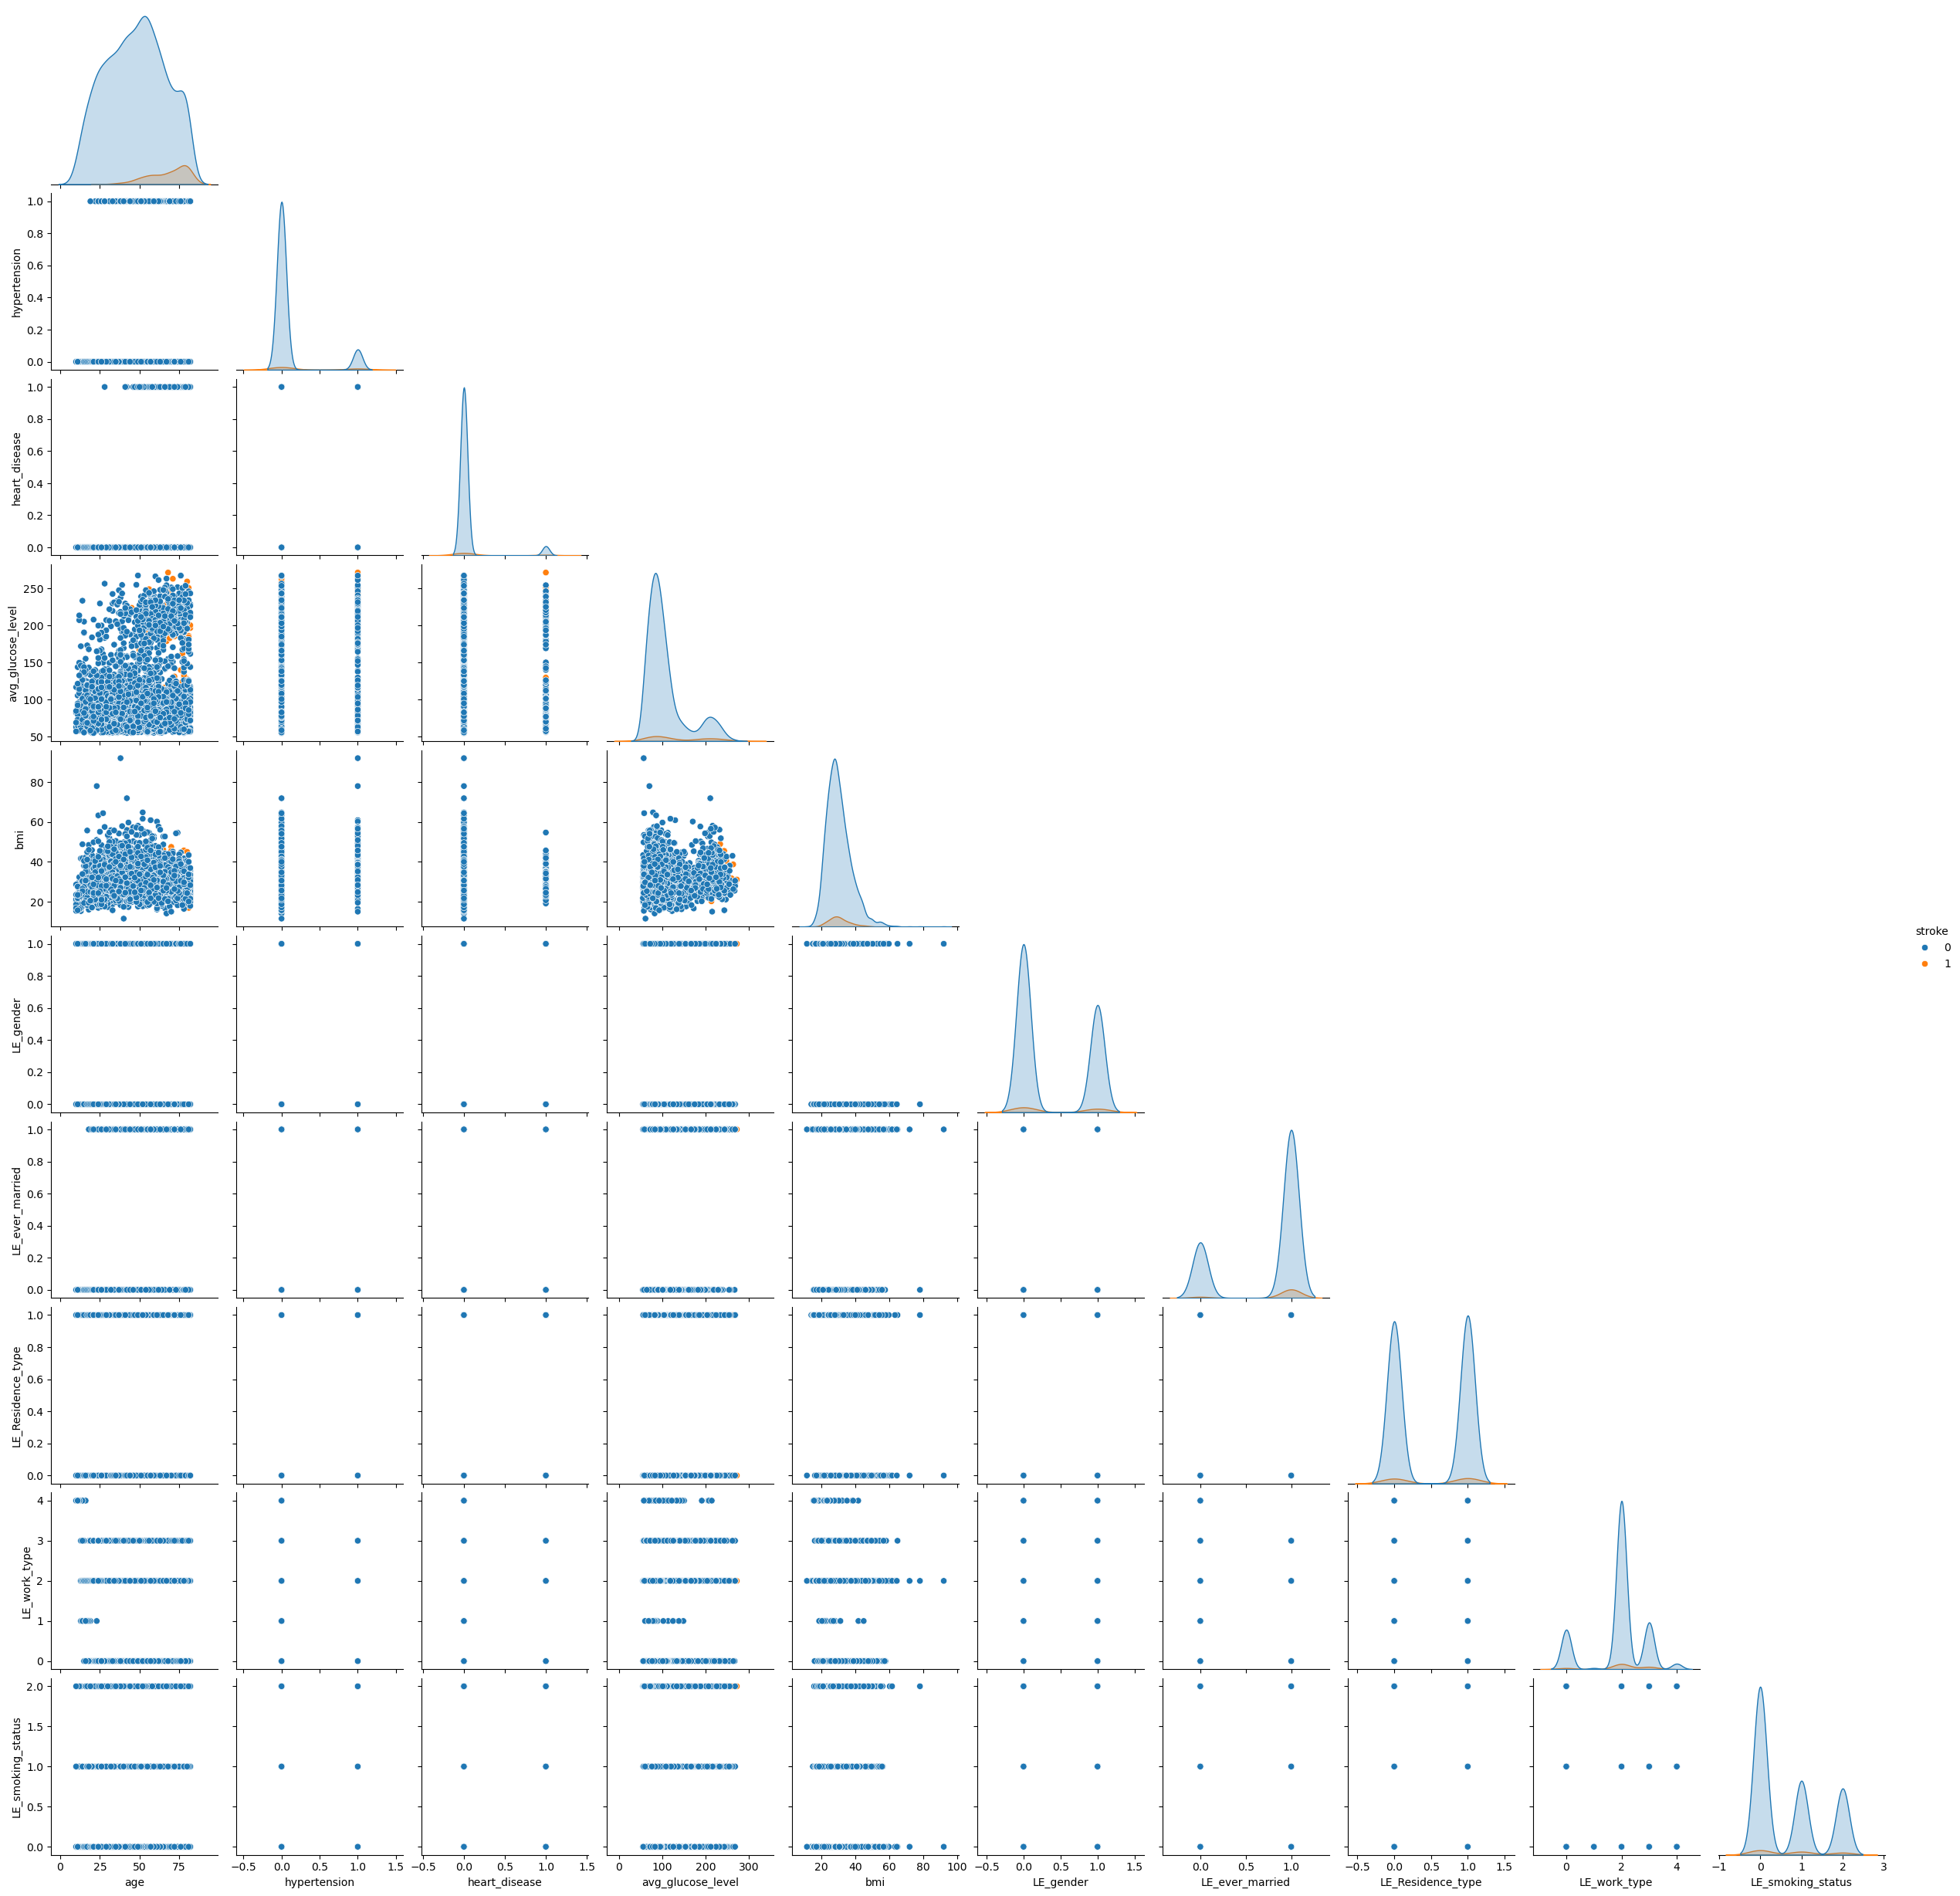

In [54]:
sns.pairplot(df, hue='stroke', diag_kind='kde', corner=True)

<Axes: >

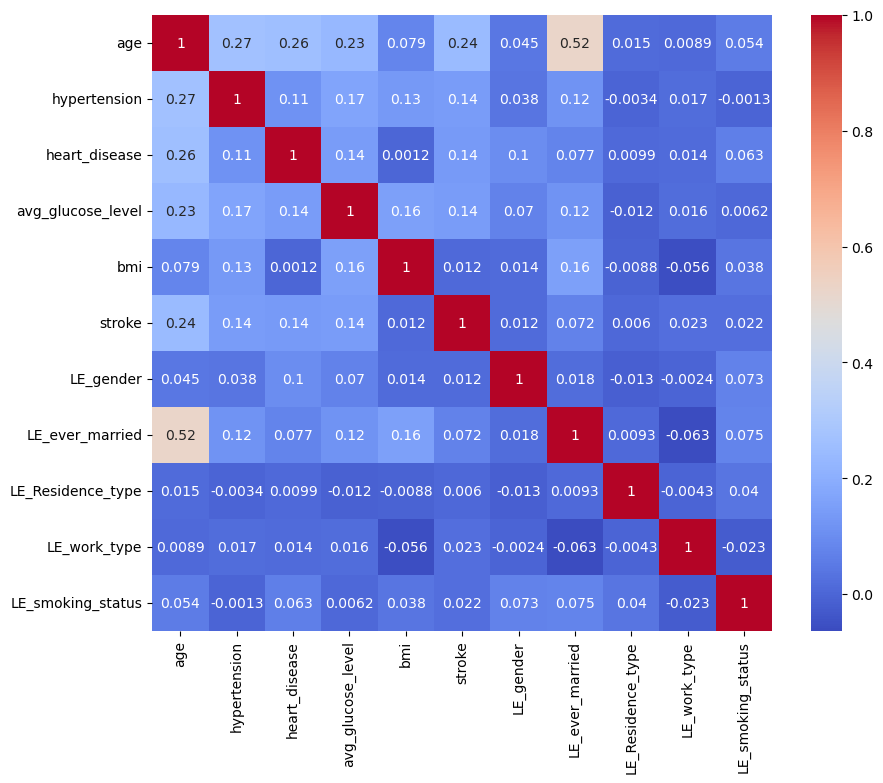

In [57]:
c=df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(c, cmap='coolwarm', annot=True)

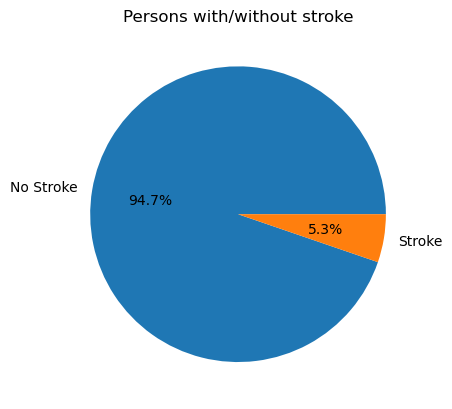

In [58]:
#I keep making the habit of making thigs waaaayyyy more complicated than they need to be...
buy = df["stroke"].value_counts()
plt.pie(buy.values, labels=['No Stroke','Stroke'],autopct='%.1f%%' )
plt.title("Persons with/without stroke");

In [ ]:
#Stroke vs Non
had_stroke = df[df['stroke']==1]
no_stroke = df[df['stroke']==0]

Text(0.5, 1.0, 'Stroke Count by Work Type')

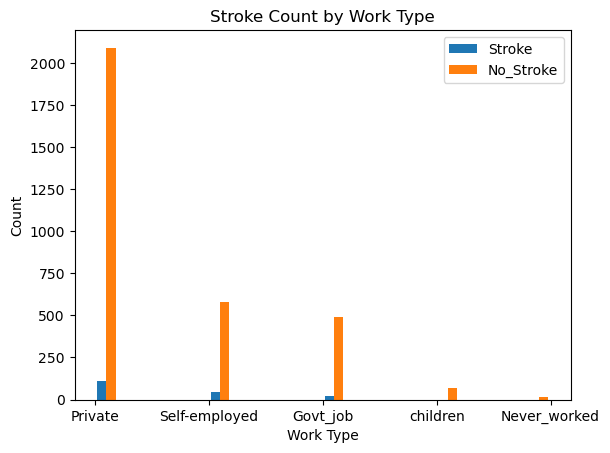

In [65]:
#plot stroke/non vs jobs
plt.hist([had_stroke['work_type'], no_stroke['work_type']], bins=20, label=['Stroke', 'No_Stroke'])
plt.legend()
plt.ylabel('Count')
plt.xlabel('Work Type')
plt.title('Stroke Count by Work Type')

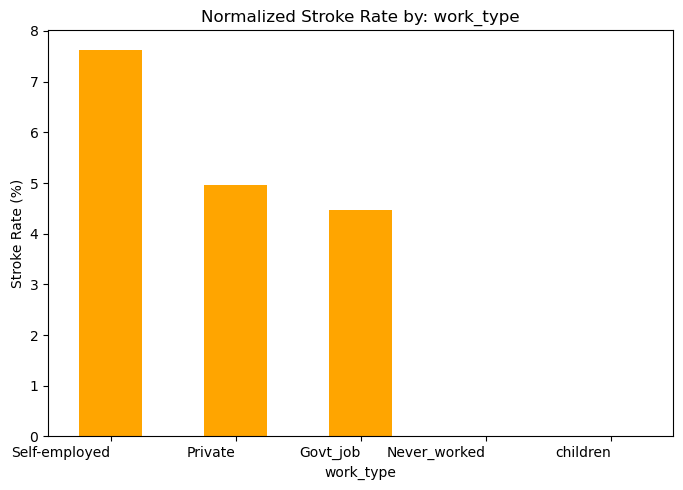

In [102]:
# Get total count per category

def plot_percentage_stroke(category):
    total_per_job = df[category].value_counts()
    
    # Get stroke count per job
    stroke_per_job = df[df['stroke'] == 1][category].value_counts()
    
    # Normalize: stroke rate per job type
    stroke_rate_per_job = (stroke_per_job / total_per_job).sort_values(ascending=False)*100
    
    # Plot
    plt.figure(figsize=(7, 5))
    stroke_rate_per_job.plot(kind='bar', color='orange')
    plt.ylabel('Stroke Rate (%)')
    plt.xlabel(category)
    title_string='Normalized Stroke Rate by: ' + category
    plt.title(title_string)
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()
    
plot_percentage_stroke('work_type')

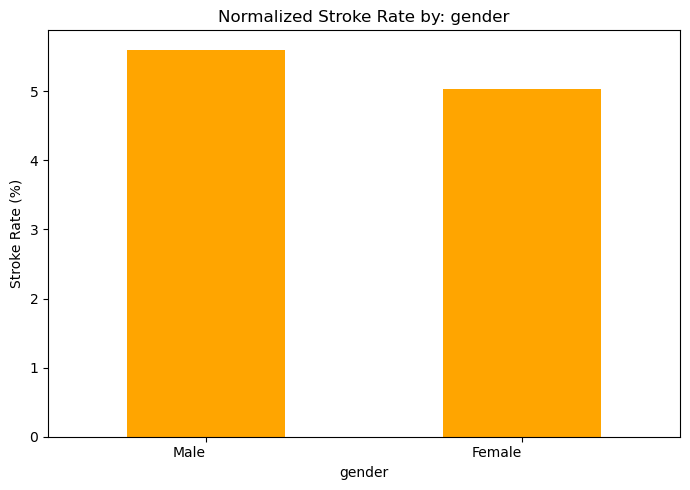

In [103]:
plot_percentage_stroke('gender')

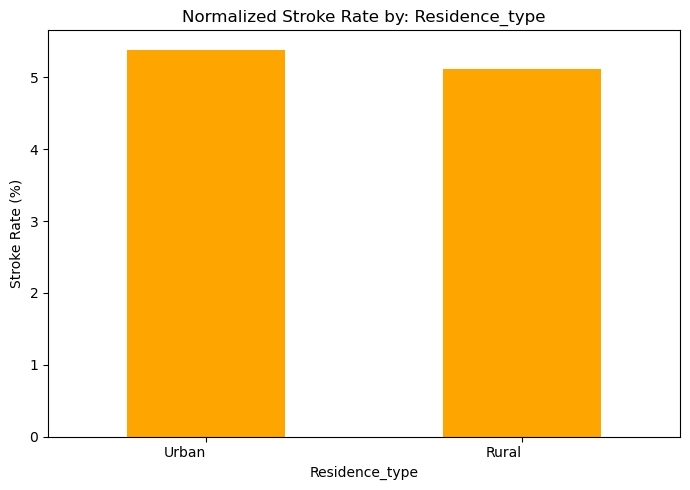

In [104]:
plot_percentage_stroke('Residence_type')

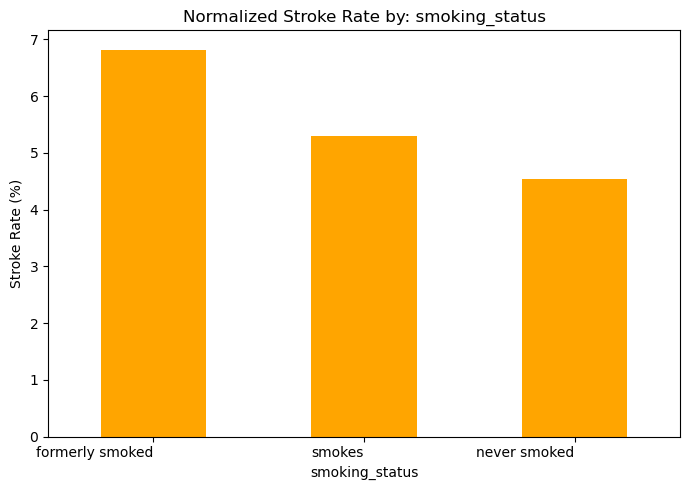

In [105]:
plot_percentage_stroke('smoking_status')

Text(0.5, 1.0, 'Stroke Count by Age')

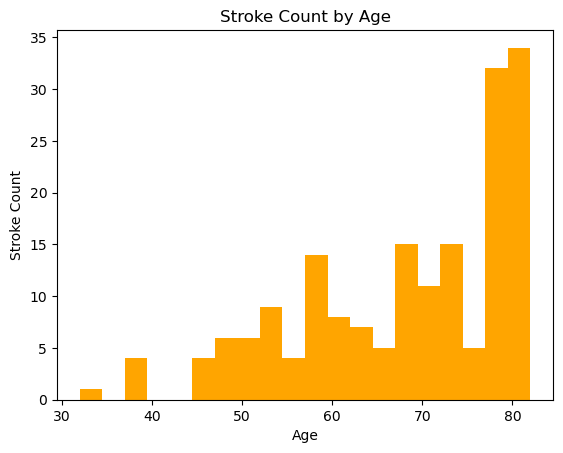

In [107]:
#Age vs Stroke
had_stroke = df[df['stroke']==1]
no_stroke = df[df['stroke']==0]
plt.hist([had_stroke['age']], bins=20, color='orange')
#plt.legend()
plt.ylabel('Stroke Count')
plt.xlabel('Age')
plt.title('Stroke Count by Age')

In [118]:
X=df.drop(['stroke', 'gender', 'ever_married', 'Residence_type', 'smoking_status', 'work_type'],  axis=1)
y=df['stroke']

In [119]:
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,LE_gender,LE_ever_married,LE_Residence_type,LE_work_type,LE_smoking_status
0,67.0,0,1,228.69,36.6,1,1,1,2,1
2,80.0,0,1,105.92,32.5,1,1,0,2,0
3,49.0,0,0,171.23,34.4,0,1,1,2,2
4,79.0,1,0,174.12,24.0,0,1,0,3,0
5,81.0,0,0,186.21,29.0,1,1,1,2,1


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model=LogisticRegression()
model.fit(X_train, y_train)
print('This models accuracy =', round(model.score(X_test,y_test)*100), '%')

This models accuracy = 95 %


,Label,Value
0,age,1.240877
3,avg_glucose_level,0.253796
1,hypertension,0.234071
9,LE_smoking_status,0.182682
2,heart_disease,0.098754
7,LE_Residence_type,0.066199
4,bmi,0.010800
8,LE_work_type,-0.046568
5,LE_gender,-0.061977
6,LE_ever_married,-0.155562


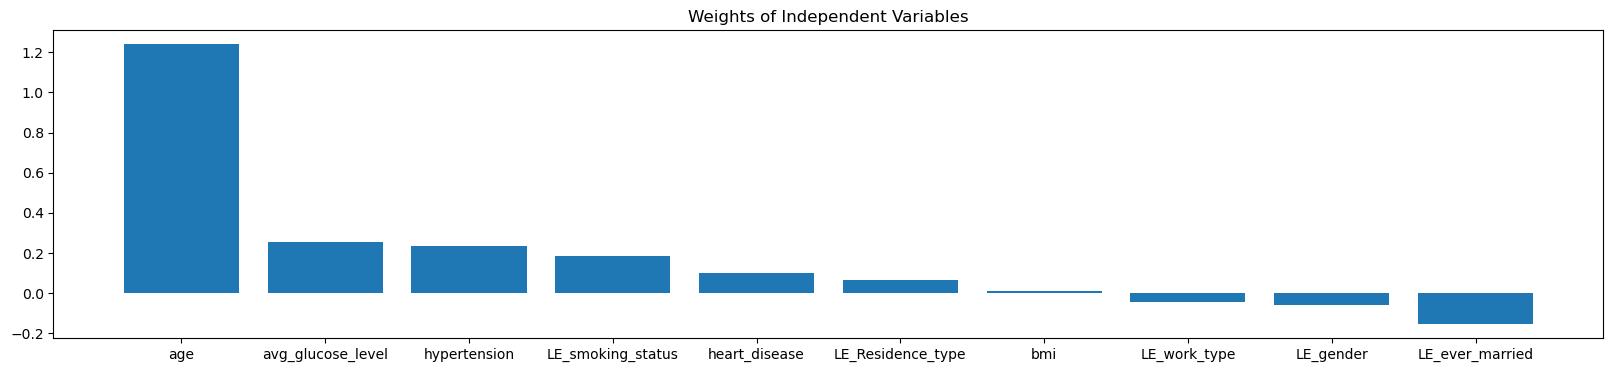

In [121]:
coefficients = model.coef_[0] 
weights_df = pd.DataFrame({'Label': X.columns, 'Value': coefficients})
weights_df = weights_df.sort_values(by='Value', ascending=False)
plt.figure(figsize=[20,4])
plt.bar(weights_df['Label'], weights_df['Value'])
plt.title("Weights of Independent Variables")
weights_df

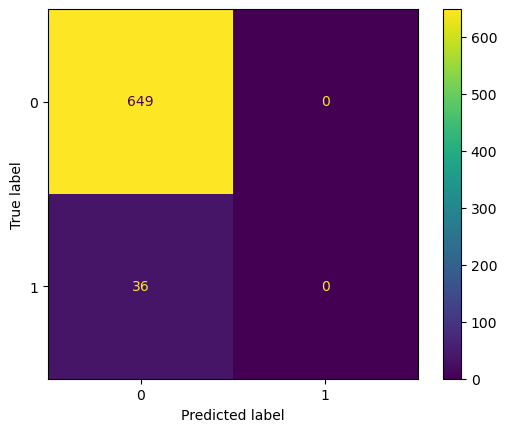

In [122]:
y_pred=model.predict(X_test)>0.5
y_true=y_test

#Confusion Matirx, displaying true/false positives/negatives
cm = confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot()

In [124]:
#The previous model has a significant issue in that it is only 96% accurate, because it is clasifying everything as non-stroke
#Attempting to remidy this by removing the independent variables with low impact on the score. 
X=df.drop(['stroke', 'gender', 'ever_married', 'Residence_type', 'smoking_status', 'work_type', 'LE_work_type', 'LE_ever_married', 'LE_gender', 'bmi', 'LE_Residence_type'],  axis=1)
y=df['stroke']

In [125]:
X.head()

,age,hypertension,heart_disease,avg_glucose_level,LE_smoking_status
0,67.0,0,1,228.69,1
2,80.0,0,1,105.92,0
3,49.0,0,0,171.23,2
4,79.0,1,0,174.12,0
5,81.0,0,0,186.21,1


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [128]:
model=LogisticRegression()
model.fit(X_train, y_train)
print('This models accuracy =', round(model.score(X_test,y_test)*100), '%')

0.9445255474452555

,Label,Value
0,age,1.229006
3,avg_glucose_level,0.227002
1,hypertension,0.207892
2,heart_disease,0.132087
4,LE_smoking_status,0.093653


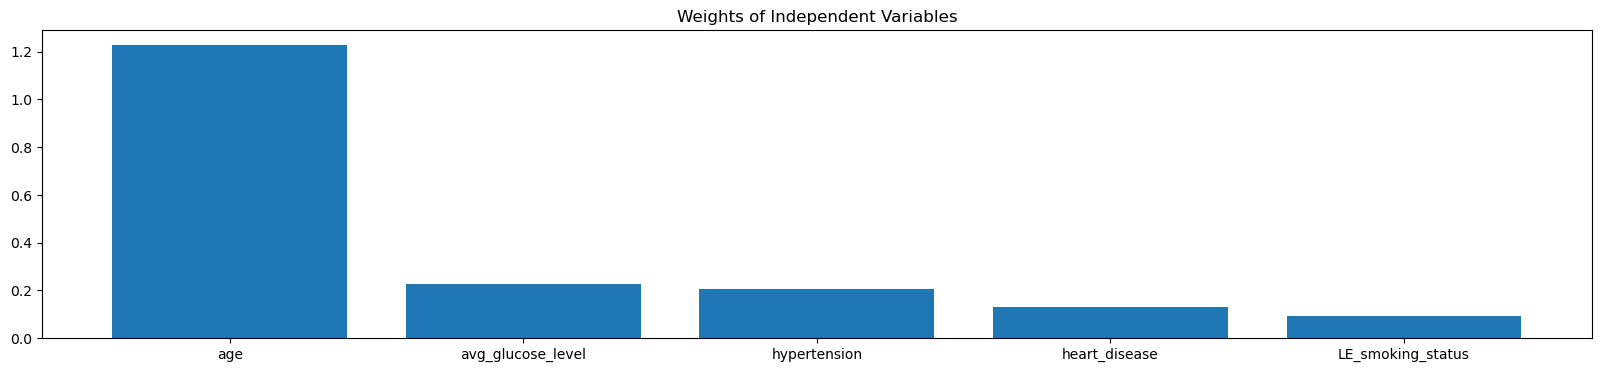

In [131]:
coefficients = model.coef_[0] 
weights_df = pd.DataFrame({'Label': X.columns, 'Value': coefficients})
weights_df = weights_df.sort_values(by='Value', ascending=False)
plt.figure(figsize=[20,4])
plt.bar(weights_df['Label'], weights_df['Value'])
plt.title("Weights of Independent Variables")
weights_df

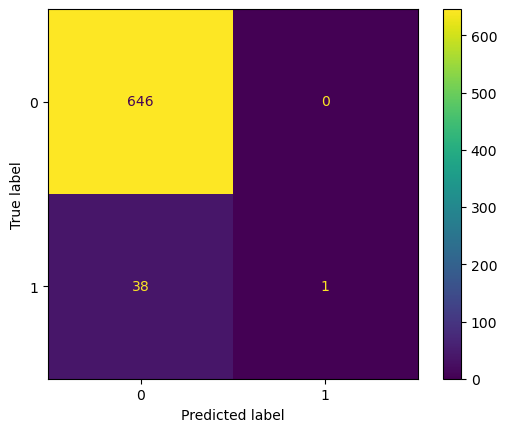

In [130]:
y_pred=model.predict(X_test)>0.5
y_true=y_test

#Confusion Matirx, displaying true/false positives/negatives
cm = confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot()

In [133]:
#The issue was still present, So now we will attempt to downsample the non-stroke instances to be a more similar sample size
#compared to the strokes.
#First split the stroke & nonstroke datasets. 
true_df = df[df['stroke'] == 1]
false_df = df[df['stroke'] == 0]

fraction=true_df.shape[0]/false_df.shape[0]

# Randomly sample % of the False rows so num of False and True cases are ~
reduced_false_df = false_df.sample(frac=fraction, random_state=42)  # use random_state for reproducibility

# Combine the reduced True samples with all False samples
balanced_df = pd.concat([true_df, reduced_false_df]).sample(frac=1)

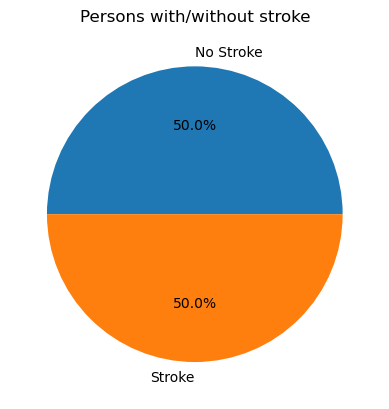

In [232]:
buy = balanced_df["stroke"].value_counts()
plt.pie(buy.values, labels=['No Stroke','Stroke'],autopct='%.1f%%' )
plt.title("Persons with/without stroke");

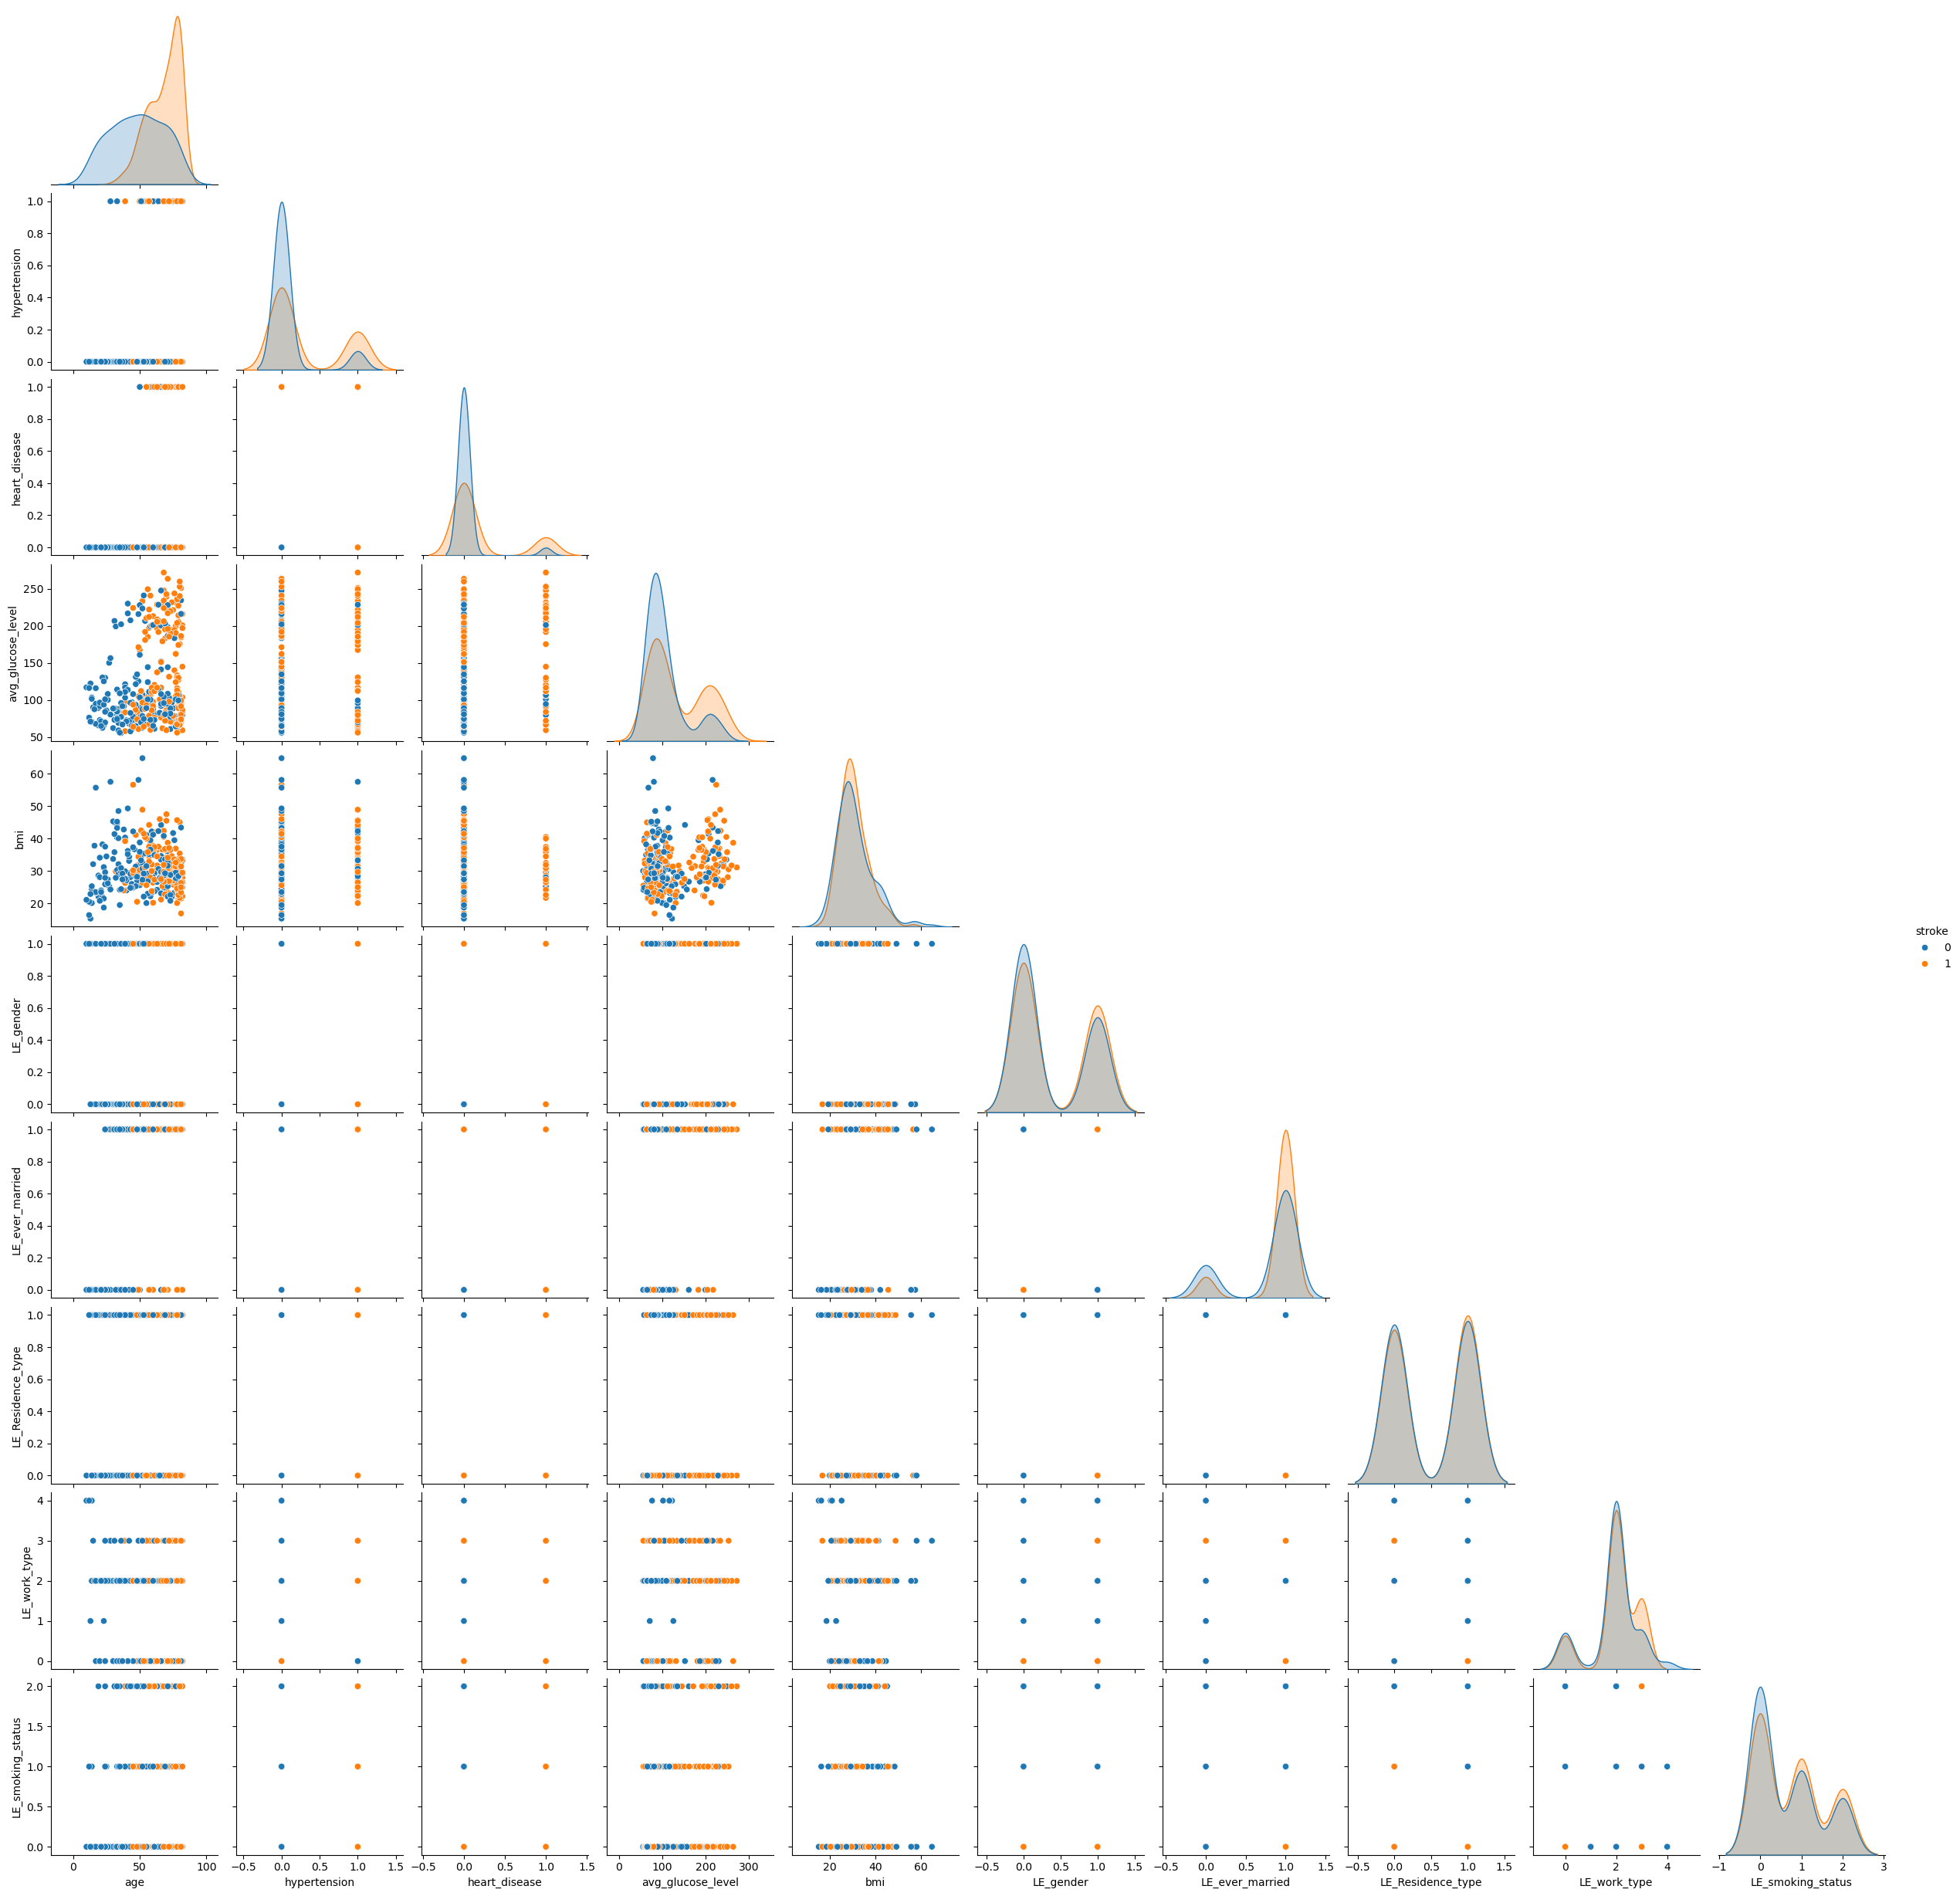

In [134]:
sns.pairplot(balanced_df, hue='stroke', diag_kind='kde', corner=True)

In [217]:
type(balanced_df)


pandas.core.frame.DataFrame

In [216]:
type(df)

pandas.core.frame.DataFrame

In [218]:
X=balanced_df.drop(['stroke', 'gender', 'ever_married', 'Residence_type', 'smoking_status', 'work_type', 'LE_work_type', 'LE_ever_married', 'LE_gender', 'bmi', 'LE_Residence_type'],  axis=1)
y=balanced_df['stroke']

In [205]:
X.head()

,age,hypertension,heart_disease,avg_glucose_level,LE_smoking_status
176,80.0,0,0,64.44,0
192,59.0,0,0,118.03,2
1356,30.0,0,0,62.25,0
3253,34.0,0,0,86.36,2
201,80.0,1,1,175.29,1


In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [220]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [221]:
model=LogisticRegression()
model.fit(X_train, y_train)
print('This models accuracy =', round(model.score(X_test,y_test)*100), '%')

This models accuracy = 82 %


,Label,Value
0,age,1.182401
3,avg_glucose_level,0.369163
1,hypertension,0.321196
4,LE_smoking_status,0.130729
2,heart_disease,0.088517


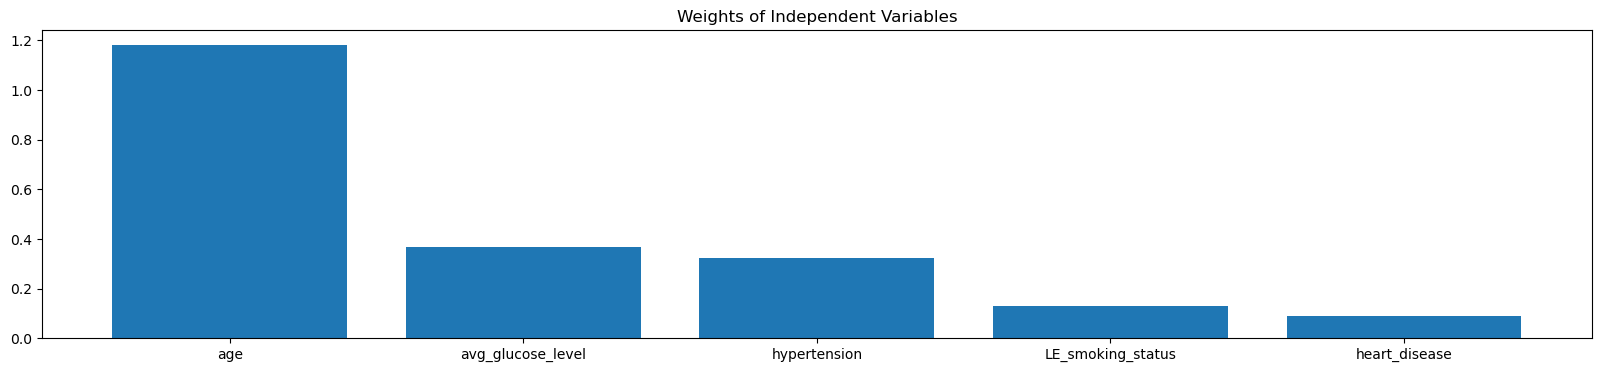

In [222]:
coefficients = model.coef_[0] 
weights_df = pd.DataFrame({'Label': X.columns, 'Value': coefficients})
weights_df = weights_df.sort_values(by='Value', ascending=False)
plt.figure(figsize=[20,4])
plt.bar(weights_df['Label'], weights_df['Value'])
plt.title("Weights of Independent Variables")
weights_df

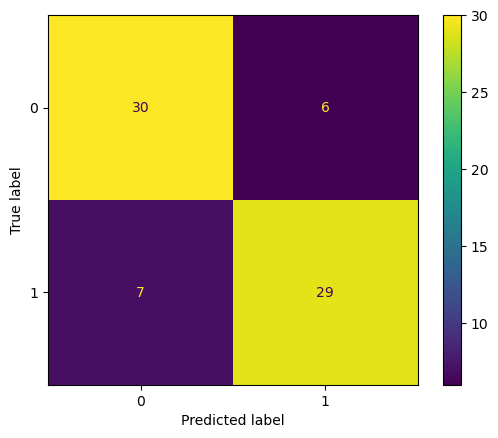

In [223]:
y_pred=model.predict(X_test)>0.5
y_true=y_test

#Confusion Matirx, displaying true/false positives/negatives
cm = confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot()

In [226]:
X_all=df.drop(['stroke', 'gender', 'ever_married', 'Residence_type', 'smoking_status', 'work_type', 'LE_work_type', 'LE_ever_married', 'LE_gender', 'bmi', 'LE_Residence_type'],  axis=1)
y_all=df['stroke']

In [227]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2)

In [228]:
scaler = StandardScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

With all Data, this models accuracy = 56 %


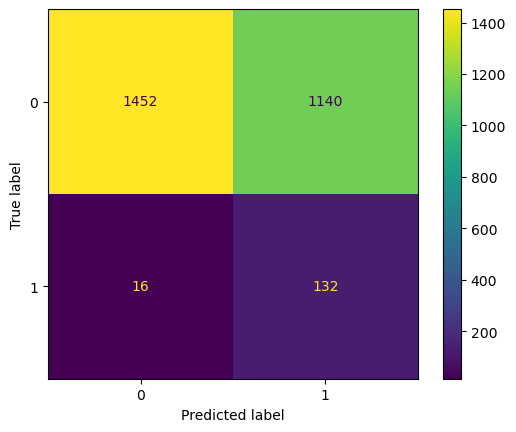

In [231]:
y_pred=model.predict(X_train_all)>0.5
y_true=y_train_all

#Confusion Matirx, displaying true/false positives/negatives
cm = confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot()
print('With all Data, this models accuracy =', round(model.score(X_test_all,y_test_all)*100), '%')